In [3]:
import torch
import matplotlib.pyplot as plt

# 协方差矩阵的计算

In [2]:
N = 10  # 样本的个数
D = 3   # 属性的个数
X = torch.randn([N,D]) # 样本矩阵

# torch自带的cov函数使用列作为样本，行作为属性
COV = torch.cov(X.T)

# 自己实现计算协方差矩阵
A = X - torch.mean(X,dim=0) # 零均值化
C = A.T @ A # 对于所有样本，属性两两之间的相乘后相加
C /= (N-1) # 协方差的校正系数

# 输出
print("调包实现：")
print(COV)
print("手动实现：")
print(C)



调包实现：
tensor([[ 0.5709,  0.0306, -0.2455],
        [ 0.0306,  0.4826, -0.2805],
        [-0.2455, -0.2805,  0.7347]])
手动实现：
tensor([[ 0.5709,  0.0306, -0.2455],
        [ 0.0306,  0.4826, -0.2805],
        [-0.2455, -0.2805,  0.7347]])


# 协方差矩阵的应用

### 作为预测模型

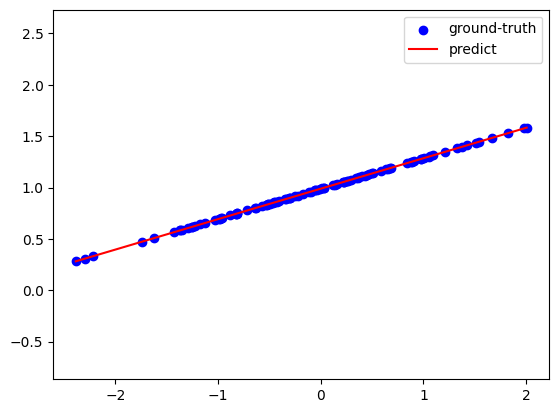

In [193]:
N = 100  # 样本的个数
X = torch.randn([N,1]) # 样本矩阵
Y = torch.rand([])*X+torch.rand([]) # 构造ground-truth

# 计算协方差
COV = torch.cov(torch.cat([X,Y],dim=1).T)
# 协方差除以方差作为斜率
w = COV[0,1] / COV[0,0]
b = torch.mean(Y-w*X)

plt.scatter(X,Y,color='b',label="ground-truth")
X_ = torch.tensor([X.min(),X.max()])
plt.plot(X_,X_*w+b,color='r',label="predict")
plt.axis('equal')
plt.legend()
plt.show()

### 作为生成模型

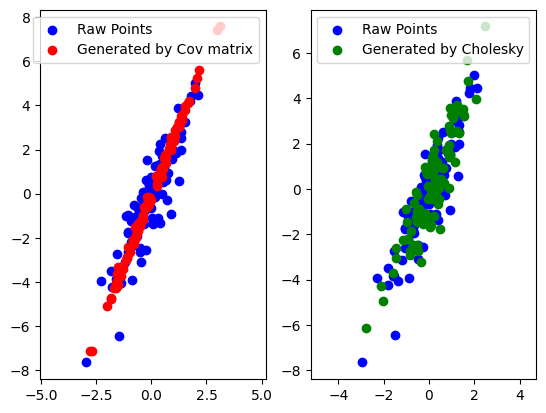

In [67]:
N = 100  # 样本的个数
D = 2   # 属性的个数
X = torch.randn([N,D]) # 样本矩阵
X[:,1] = X[:,1]*1 + X[:,0]*2

# torch自带的cov函数使用列作为样本，行作为属性
COV = torch.cov(X.T)

# 随机从高斯分布中采样一些样本
Z = torch.randn([N,D])
# 尝试将COV作为生成模型
W0 = Z @ COV
W1 = Z @ torch.linalg.cholesky(COV).T

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='b',label="Raw Points")
plt.scatter(W0[:,0],W0[:,1],color='r',label="Generated by Cov matrix")
plt.axis('equal')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X[:,0],X[:,1],color='b',label="Raw Points")
plt.scatter(W1[:,0],W1[:,1],color='g',label="Generated by Cholesky")
plt.axis('equal')
plt.legend()

plt.show()

- 在上面的代码中，我们尝试：
    - 使用协方差矩阵直接将高斯噪声变换到目标分布，结果失败
    - 在对协方差矩阵使用Cholesky分解后进行变换，却成功了
- 这是为什么？让我们从Cholesky分解的性质出发：
    - 首先，它是一种三角分解，可以将**实半正定阵**$A$分解为$A=LL^T$，其中$L$为下三角矩阵
    - 我的理解是：由于协方差矩阵是对称矩阵，直接将其作用于样本相当于进行了两次变换，所以要进行分解

- 其实，用特征值分解也可以达到相同的效果，可以通过对特征值的对角阵开根号来分解为$L$与$L^T$
$$ \begin{aligned} A &= V \Sigma V^T \\ &= (V \Sigma^{1/2}) (\Sigma^{1/2} V^T)  \end{aligned} $$

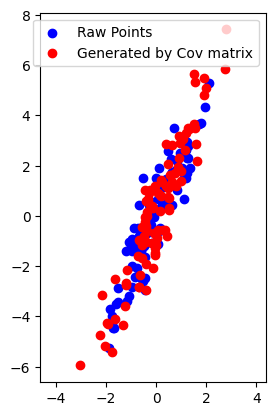

In [89]:
N = 100  # 样本的个数
D = 2   # 属性的个数
X = torch.randn([N,D]) # 样本矩阵
X[:,1] = X[:,1]*1 + X[:,0]*2

# torch自带的cov函数使用列作为样本，行作为属性
COV = torch.cov(X.T)

# 对其进行特征值分解
# 协方差矩阵实对称，所以使用eigh而不是eig
# 这样更快，且直接返回实部
S,V = torch.linalg.eigh(COV)
# 把特征值从向量变成对角阵
S = torch.diag(S)
# 特征值开根号，从而将VSV^T变成VS SV^T
S = torch.sqrt(S)

# 随机从高斯分布中采样一些样本
Z = torch.randn([N,D])

# 尝试将COV作为生成模型
W = Z @ S @ V.T

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='b',label="Raw Points")
plt.scatter(W[:,0],W[:,1],color='r',label="Generated by Cov matrix")
plt.axis('equal')
plt.legend()

plt.show()

# 精度矩阵

### 使用精度矩阵进行去相关

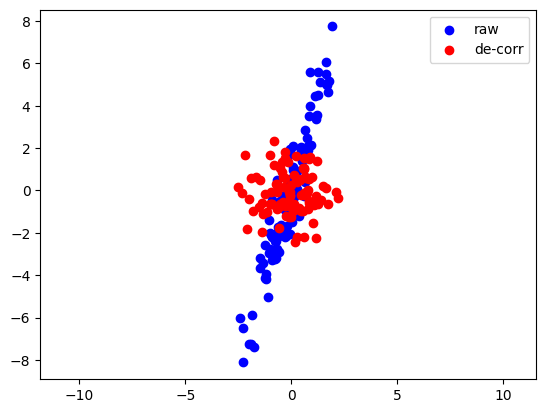

In [177]:
N = 100
X = torch.randn([N,2])
X[:,1] = X[:,0] * 3 + X[:,1] * 1

# 计算协方差矩阵
C = torch.cov(X.T)
# 计算精度矩阵
P = torch.inverse(C)

# 去相关
Z = X @ torch.linalg.cholesky(P)
plt.scatter(X[:,0],X[:,1],color='b',label="raw")
plt.scatter(Z[:,0],Z[:,1],color='r',label="de-corr")

plt.axis('equal')
plt.legend()
plt.show()